# Setup

In [1]:
#GPU runtime required, should give CUDA version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [2]:
!pip install faiss-gpu
!pip install fuzzy-c-means

     |████████████████████████████████| 85.5 MB 82 kB/s 
     |████████████████████████████████| 10.9 MB 3.3 MB/s 


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!cp -r /content/gdrive/MyDrive/Explainable_Wound_Classification/CMSF/self_supervised/* /content
root_path = 'gdrive/MyDrive/Explainable_Wound_Classification/'

In [5]:
import builtins
import os
import sys
import time
import argparse
import random
import copy
from collections import Counter, OrderedDict
from random import shuffle

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets, models

from PIL import ImageFilter, Image
from util import adjust_learning_rate, AverageMeter as AvgMeter, subset_classes

import pdb
import faiss
from fcmeans import FCM

import numpy as np
from scipy import stats
import pandas as pd
import re
from collections import namedtuple

import shutil
import warnings

import torch.nn.parallel
import torch.optim
import torch.utils.data
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tools import *

#CMSF-KM

### Misc Functions

In [6]:
def get_mlp(inp_dim, hidden_dim, out_dim):
    mlp = nn.Sequential(
        nn.Linear(inp_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, out_dim),
    )
    return mlp

In [7]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

In [8]:
def faiss_kmeans(feats, nmb_clusters):
    feats = feats.numpy()
    d = feats.shape[-1]
    clus = faiss.Clustering(d, nmb_clusters)
    clus.niter = 20
    clus.max_points_per_centroid = 10000000

    index = faiss.IndexFlatL2(d)
    co = faiss.GpuMultipleClonerOptions()
    co.useFloat16 = True
    co.shard = True
    index = faiss.index_cpu_to_all_gpus(index, co)

    # perform the training
    clus.train(feats, index)
    _, train_a = index.search(feats, 1)

    return list(train_a[:, 0])

In [9]:
def fuzzy_c_means(feats, nmb_clusters):
    feats = feats.numpy()
    
    fcm = FCM(n_clusters=nmb_clusters)
    fcm.fit(feats)

    return fcm.predict(feats), fcm

In [10]:
def get_shuffle_ids(bsz):
    """generate shuffle ids for ShuffleBN"""
    forward_inds = torch.randperm(bsz).long().cuda()
    backward_inds = torch.zeros(bsz).long().cuda()
    value = torch.arange(bsz).long().cuda()
    backward_inds.index_copy_(0, forward_inds, value)
    return forward_inds, backward_inds


### Model Architecture

In [11]:
def initialize_encoder(model_name, output_dim, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, output_dim)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,output_dim)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,output_dim)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        model_ft.classifier[1] = nn.Conv2d(512, output_dim, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = output_dim
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, output_dim)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, output_dim)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,output_dim)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [12]:
class ConstrainedMeanShiftKM(nn.Module):
    def __init__(self, arch, m=0.99, mem_bank_size=128000, topk=5, dataset_size=100, num_clusters=4, output_dim=16):
        super(ConstrainedMeanShiftKM, self).__init__()

        # save parameters
        self.m = m
        self.mem_bank_size = mem_bank_size
        self.topk = topk
        self.dataset_size = dataset_size
        self.num_clusters = num_clusters

        # create encoders and projection layers
        # both encoders should have same arch
        self.encoder_q = initialize_encoder(arch, output_dim)[0]
        self.encoder_t = initialize_encoder(arch, output_dim)[0]

        # prediction layer
        self.predict_q = get_mlp(output_dim, output_dim * 2, output_dim)

        # copy query encoder weights to target encoder
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data.copy_(param_q.data)
            param_t.requires_grad = False

        print("using mem-bank size {}".format(self.mem_bank_size))
        # setup queue (For Storing Random Targets)
        self.register_buffer('queue', torch.randn(self.mem_bank_size, output_dim))
        self.register_buffer('pool', torch.randn(self.dataset_size, output_dim))
        self.register_buffer('pseudo_labels', 0*torch.ones(self.dataset_size).long())
        # normalize the queue embeddings
        self.queue = nn.functional.normalize(self.queue, dim=1)
        # initialize the labels queue (For Purity measurement)
        self.register_buffer('labels', -1*torch.ones(self.mem_bank_size).long())
        self.register_buffer('index_queue', -1 * torch.ones(self.mem_bank_size).long())
        # setup the queue pointer
        self.register_buffer('queue_ptr', torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_target_encoder(self):
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data = param_t.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def data_parallel(self):
        self.encoder_q = torch.nn.DataParallel(self.encoder_q)
        self.encoder_t = torch.nn.DataParallel(self.encoder_t)
        self.predict_q = torch.nn.DataParallel(self.predict_q)

    @torch.no_grad()
    def cluster(self):
        print('start clustering ... num clusters: {}'.format(self.num_clusters))
        cluster_assignment, cluster_model = fuzzy_c_means(self.pool.clone().cpu(), self.num_clusters)
        self.pseudo_labels = torch.tensor(cluster_assignment).cuda()
        return cluster_model

    @torch.no_grad()
    def _dequeue_and_enqueue(self, targets, labels, indices):
        batch_size = targets.shape[0]

        ptr = int(self.queue_ptr)
        assert self.mem_bank_size % batch_size == 0 

        # replace the targets at ptr (dequeue and enqueue)
        self.pool[indices, :] = targets
        self.queue[ptr:ptr + batch_size] = targets
        self.labels[ptr:ptr + batch_size] = labels
        self.index_queue[ptr:ptr + batch_size] = indices
        ptr = (ptr + batch_size) % self.mem_bank_size  # move pointer

        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_t, labels, indices):
        # compute query features
        feat_q = self.encoder_q(im_q)
        # compute predictions for instance level regression loss
        query = self.predict_q(feat_q)
        query = nn.functional.normalize(query, dim=1)

        # compute target features
        with torch.no_grad():
            # update the target encoder
            self._momentum_update_target_encoder()

            # shuffle targets
            shuffle_ids, reverse_ids = get_shuffle_ids(im_t.shape[0])
            im_t = im_t[shuffle_ids]

            # forward through the target encoder
            current_target = self.encoder_t(im_t)
            current_target = nn.functional.normalize(current_target, dim=1)

            # undo shuffle
            current_target = current_target[reverse_ids].detach()

            # update the memory-bank
            self._dequeue_and_enqueue(current_target, labels, indices)

        targets = self.queue.clone().detach()

        # get pseudo of target and memory bank samples
        current_target_pseudo_labels = self.pseudo_labels[indices]
        targets_pseudo_labels = self.pseudo_labels[self.index_queue]

        # create a mask to constrain the search space
        b = current_target_pseudo_labels.shape[0]
        m = targets_pseudo_labels.shape[0]
        lx = current_target_pseudo_labels.unsqueeze(1).expand((b, m))
        lm = targets_pseudo_labels.unsqueeze(0).expand((b, m))
        msk = lx != lm

        # calculate distances between vectors
        dist_t = 2 - 2 * torch.einsum('bc,kc->bk', [current_target, targets])
        dist_q = 2 - 2 * torch.einsum('bc,kc->bk', [query, targets])

        # select the k nearest neighbors [with smallest distance (largest=False)] based on current target
        _, unconstrained_nn_index = dist_t.topk(self.topk, dim=1, largest=False)

        # select the k nearest neighbors based on constrained memory bank
        dist_t[torch.where(msk)] = 5.0
        _, constrained_nn_index = dist_t.topk(self.topk, dim=1, largest=False)

        # calculate mean shift regression loss
        nn_dist_q_constrained = torch.gather(dist_q, 1, constrained_nn_index)
        nn_dist_q_unconstrained = torch.gather(dist_q, 1, unconstrained_nn_index)

        # purity based on memory bank
        labels = labels.unsqueeze(1).expand(nn_dist_q_unconstrained.shape[0], nn_dist_q_unconstrained.shape[1])
        labels_queue = self.labels.clone().detach()
        labels_queue = labels_queue.unsqueeze(0).expand((nn_dist_q_unconstrained.shape[0], self.mem_bank_size))
        labels_queue = torch.gather(labels_queue, dim=1, index=unconstrained_nn_index)
# TODO: Change matches here
        matches = (labels_queue == labels).float()
        purity = (matches.sum(dim=1) / self.topk).mean()

        loss = ((nn_dist_q_constrained.sum(dim=1) / self.topk).mean()
                + (nn_dist_q_unconstrained.sum(dim=1) / self.topk).mean()) / 2.0

        return loss, purity

### Transformations/Data Loading

In [13]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and target."""
    def __init__(self, weak_transform, strong_transform):
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        print(self.weak_transform)
        print(self.strong_transform)

    def __call__(self, x):
        q = self.strong_transform(x)
        t = self.weak_transform(x)
        return [q, t]


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [14]:
class Image_Dataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, label_fn, transform=None):
        """
        Image dataset. Returns tensorized images and labels with index
        Args:
            root_dir: path to a cropped mouse image dataset.
            label_fn: function that returns the correct label given an image name
        """
        self.root_dir = root_dir
        self.label_fn = label_fn
        self.transform = transform

        samples = []
        targets = []
        for f in os.listdir(root_dir):
            samples.append(os.path.join(root_dir, f))
            targets.append(label_fn(f))
        
        self.samples = samples
        self.targets = targets

    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
            """
            Returns index, tensor data, and tensorized label.
            """
            img = self.pil_loader(self.samples[index])
            target = self.targets[index]

            if self.transform:
                img = self.transform(img)

            return index, img, torch.tensor(target)

    def __len__(self):
        return len(self.samples)

    def __str__(self):
        return "Image_Dataset:\n" + "Found " + str(len(self)) + " images in " + self.root_dir + "\n"

In [15]:
# Create train loader
def get_train_loader(datapath, label_fn, batch_size, num_workers, weak_strong=True):
    traindir = os.path.join(datapath, 'train')
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean=mean, std=std)

    augmentation_strong = [
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        #transforms.Resize(224),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        #transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(saturation=(0,1)),
        transforms.RandomRotation((0, 360)),
        #transforms.RandomAffine((0,0), translate=(0.3, 0.3)),
        transforms.ToTensor(),
        normalize
    ]

    augmentation_weak = [
        #transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((0, 360)),
        transforms.ToTensor(),
        normalize,
    ]

    if weak_strong:
        train_dataset = Image_Dataset(
            traindir, label_fn, 
            TwoCropsTransform(transforms.Compose(augmentation_weak), transforms.Compose(augmentation_strong))
        )
    else:
        train_dataset = Image_Dataset(
            traindir, label_fn, 
            TwoCropsTransform(transforms.Compose(augmentation_strong), transforms.Compose(augmentation_strong))
        )

    print('==> train dataset')
    print(train_dataset)

    # NOTE: remove drop_last
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True)

    return train_loader

In [16]:
def get_val_loader(datapath, label_fn, num_workers, batch_size=-1, test=False, train=False):
    if test:
        valdir = os.path.join(datapath, 'test')
    elif train:
        valdir = os.path.join(datapath, 'train')
    else:
        valdir = os.path.join(datapath, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    val_transform = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = Image_Dataset(valdir, label_fn, val_transform)

    if batch_size == -1:
        batch_size = len(dataset)

    val_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True,
    )
    return val_loader, dataset.samples

### Training Functions

In [17]:
def train(epoch, train_loader, mean_shift, optimizer, print_freq):
    """
    one epoch training
    """
    mean_shift.train()

    batch_time = AvgMeter()
    data_time = AvgMeter()
    loss_meter = AvgMeter()
    purity_meter = AvgMeter()

    end = time.time()
    for idx, (indices, (im_q, im_t), labels) in enumerate(train_loader):
        data_time.update(time.time() - end)
        im_q = im_q.cuda(non_blocking=True)
        im_t = im_t.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        # ===================forward=====================
        loss, purity = mean_shift(im_q=im_q, im_t=im_t, labels=labels, indices=indices)

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        loss_meter.update(loss.item(), im_q.size(0))
        purity_meter.update(purity.item(), im_q.size(0))

        torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'purity {purity.val:.3f} ({purity.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})\t'.format(
                   epoch, idx + 1, len(train_loader), batch_time=batch_time,
                   data_time=data_time,
                   purity=purity_meter,
                   loss=loss_meter))
            sys.stdout.flush()
            sys.stdout.flush()

    

    return loss_meter.avg, purity_meter.avg

In [18]:
#workaround struct to pass args to util script
LRArgs = namedtuple('LRArgs', ['cos', 'learning_rate', 'epochs', 'lr_decay_rate'])

In [19]:
def cmsf_km_main(data_path, checkpoint_path, label_fn, batch_size=16, num_workers=2, 
                 epochs=200, print_freq=10, save_freq=10, weak_strong=True, 
                 debug=False, arch='resnet50', momentum=0.99, mem_bank_size=128000, 
                 topk=5, num_clusters=4, learning_rate=0.05, sgd_momentum=0.9, 
                 weight_decay=1e-4, weights=None, resume=None, cos=True, 
                 lr_decay_rate=0.2, output_dim=16):
    """
    todo: docstring
    """
    opt = locals()
    del opt['label_fn']

    if (not resume) and (not weights):
        os.makedirs(checkpoint_path)

    train_loader = get_train_loader(data_path, label_fn, batch_size, num_workers, weak_strong)

    mean_shift = ConstrainedMeanShiftKM(
        arch,
        m=momentum,
        mem_bank_size=mem_bank_size,
        topk=topk,
        dataset_size=len(train_loader.dataset),
        num_clusters=num_clusters,
        output_dim=output_dim
    )

    mean_shift.data_parallel()
    mean_shift = mean_shift.cuda()
    print(mean_shift)


    print("Params to learn:")
    for name,param in mean_shift.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    params = [p for p in mean_shift.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params,
                                lr=learning_rate,
                                momentum=sgd_momentum,
                                weight_decay=weight_decay)

    cudnn.benchmark = True
    start_epoch = 1

    history_df = pd.DataFrame(index=range(start_epoch, epochs + 1))

    if weights:
        print('==> load weights from checkpoint: {}'.format(weights))
        ckpt = torch.load(weights)
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        if 'model' in ckpt:
            sd = ckpt['model']
        else:
            sd = ckpt['state_dict']
        msg = mean_shift.load_state_dict(sd, strict=False)
        optimizer.load_state_dict(ckpt['optimizer'])
        start_epoch = ckpt['epoch'] + 1
        print(msg)
    

    if resume:
        print('==> resume from checkpoint: {}'.format(resume))
        ckpt = torch.load(resume, map_location='cpu')
        # sd = ckpt['state_dict']
        # sd = {k.replace('module.', ''): v for k, v in sd.items()}
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        mean_shift.load_state_dict(ckpt['state_dict'], strict=True)
        optimizer.load_state_dict(ckpt['optimizer'])
        start_epoch = ckpt['epoch'] + 1
        history_df = ckpt['history_df']

    lr_args = LRArgs(cos, learning_rate, epochs, lr_decay_rate)

    for epoch in range(start_epoch, epochs + 1):

        adjust_learning_rate(epoch, lr_args, optimizer)
        print("==> training...")

        time1 = time.time()

        loss, purity = train(epoch, train_loader, mean_shift, optimizer, print_freq)
        cluster_model = mean_shift.cluster()

        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        history_df.loc[epoch, 'loss'] = loss
        history_df.loc[epoch, 'purity'] = purity

        # saving the model
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'opt': opt,
                'state_dict': mean_shift.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'history_df': history_df
            }

            save_file = os.path.join(checkpoint_path, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

            # help release GPU memory
            del state
            torch.cuda.empty_cache()

### Getting Label Assignments

In [20]:
labels_df = pd.read_csv(root_path + 'Updated_Cropped_Images_Wound_Stage_Probabilities.csv', index_col='Image')
labels_df.head()

,hemostasis,inflammatory,proliferative,maturation
Image,,,,
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.000000
Day 14_Y8-4-L.png,0.000000,0.000000,0.090909,0.909091
Day 7_Y8-4-L.png,0.000000,0.000000,0.454545,0.545455
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000


In [21]:
labels_df['label'] = labels_df.index.map(lambda x: labels_df.loc[x].argmax())
labels_df.head()

,hemostasis,inflammatory,proliferative,maturation,label
Image,,,,,
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818,2
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.000000,1
Day 14_Y8-4-L.png,0.000000,0.000000,0.090909,0.909091,3
Day 7_Y8-4-L.png,0.000000,0.000000,0.454545,0.545455,3
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000,1


In [22]:
labels_map = labels_df['label']
labels_map.head()

Image
Day 8_A8-4-L.png     2
Day 4_A8-3-R.png     1
Day 14_Y8-4-L.png    3
Day 7_Y8-4-L.png     3
Day 2_A8-1-L.png     1
Name: label, dtype: int64

### Folder to store outputs and number of epochs to run

In [25]:
train_folder_name = 'unsupervised/5_default_transforms/'
epochs = 200

# CMSF-KM Training

### Training

In [26]:
cmsf_km_main(
    data_path=root_path + 'Split_images', 
    checkpoint_path=root_path + 'outputs/' + train_folder_name, 
    label_fn=lambda x: labels_map[x],
    batch_size=8,
    num_workers=2,
    epochs=epochs,
    arch='resnet',
    batch_size=8,
    num_clusters=4,
    learning_rate=0.05,
    mem_bank_size=128000,
    topk=5,
    weak_strong=True,
    output_dim=16,
    debug=False)

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.2, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomApply(
    p=0.8
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.1, 0.1])
)
    RandomGrayscale(p=0.2)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
==> train dataset
Image_Dataset:
Found 191 images in gdrive/MyDrive/Explainable_Wound_Classification/Split_images/train



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

using mem-bank size 128000
ConstrainedMeanShiftKM(
  (encoder_q): DataParallel(
    (module): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddin

### Graphs

In [27]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + str(epochs) + '.pth')
history_df = cpkt['history_df']

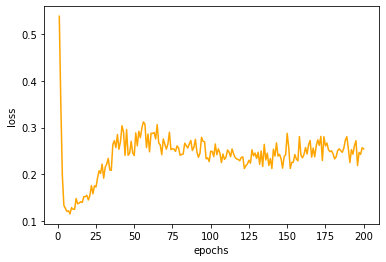

In [28]:
_ = history_df['loss'].plot.line(xlabel='epochs', ylabel='loss', color='orange')

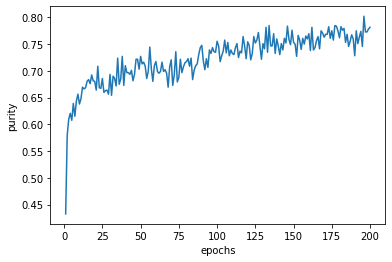

In [29]:
_ = history_df['purity'].plot.line(xlabel='epochs', ylabel='purity')

# Linear Evaluation

### Misc Setup

In [30]:
def load_weights(model, wts_path, output_dim):
    wts = torch.load(wts_path)
    # pdb.set_trace()
    if 'state_dict' in wts:
        ckpt = wts['state_dict']
    elif 'model' in wts:
        ckpt = wts['model']
    else:
        ckpt = wts

    ckpt = {k.replace('module.', ''): v for k, v in ckpt.items()}
    ckpt = {k: v for k, v in ckpt.items() if 'encoder_t' not in k}
    ckpt = {k.replace('encoder_q.', ''): v for k, v in ckpt.items()}
    state_dict = {}

    for m_key, m_val in model.state_dict().items():
        if m_key in ckpt:
            state_dict[m_key] = ckpt[m_key]
        else:
            state_dict[m_key] = m_val
            print('not copied => ' + m_key)

    model.load_state_dict(state_dict)

    predict_q_ckpt = {k: v for k, v in ckpt.items() if 'predict_q' in k}
    predict_q_ckpt = {k.replace('predict_q.', ''): v for k, v in predict_q_ckpt.items()}
    predict_q_model = get_mlp(output_dim, output_dim * 2, output_dim)

    predict_q_state_dict = {}

    for m_key, m_val in predict_q_model.state_dict().items():
        if m_key in predict_q_ckpt:
            predict_q_state_dict[m_key] = predict_q_ckpt[m_key]
        else:
            predict_q_state_dict[m_key] = m_val
            print('not copied => ' + m_key)

    predict_q_model.load_state_dict(predict_q_state_dict)

    model.fc = nn.Sequential(model.fc, predict_q_model)

In [31]:
def get_model(arch, output_dim, wts_path):
    model, _ = initialize_encoder(arch, output_dim)
    load_weights(model, wts_path, output_dim)

    # if arch == 'alexnet':
    #     model = AlexNet()
    #     model.fc = nn.Sequential()
    #     load_weights(model, wts_path)
    # elif arch == 'pt_alexnet':
    #     model = models.alexnet()
    #     classif = list(model.classifier.children())[:5]
    #     model.classifier = nn.Sequential(*classif)
    #     load_weights(model, wts_path)
    # elif arch == 'mobilenet':
    #     model = MobileNetV2()
    #     model.fc = nn.Sequential()
    #     load_weights(model, wts_path)
    # elif 'sup_resnet' in arch:
    #     model = models.__dict__[arch.replace('sup_', '')](pretrained=True)
    #     model.fc = nn.Sequential()
    # elif 'resnet' in arch:
    #     model = models.__dict__[arch]()
    #     model.fc = nn.Sequential()
    #     load_weights(model, wts_path)
    # else:
    #     raise ValueError('arch not found: ' + arch)

    for p in model.parameters():
        p.requires_grad = False

    return model

In [32]:
class Normalize(nn.Module):
    def forward(self, x):
        return x / x.norm(2, dim=1, keepdim=True)


class FullBatchNorm(nn.Module):
    def __init__(self, var, mean):
        super(FullBatchNorm, self).__init__()
        self.register_buffer('inv_std', (1.0 / torch.sqrt(var + 1e-5)))
        self.register_buffer('mean', mean)

    def forward(self, x):
        return (x - self.mean) * self.inv_std

In [33]:
def get_channels(arch):
    if arch == 'alexnet':
        c = 4096
    elif arch == 'pt_alexnet':
        c = 4096
    elif 'resnet50' in arch:
        c = 2048
    elif arch == 'resnet18':
        c = 512
    elif arch == 'mobilenet':
        c = 1280
    else:
        raise ValueError('arch not found: ' + arch)
    return c

In [34]:
def normalize(x):
    return x / x.norm(2, dim=1, keepdim=True)

In [35]:
def get_feats(loader, model, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(loader),
        [batch_time],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    feats, labels, ptr = None, None, 0

    with torch.no_grad():
        end = time.time()
        for i, (indices, images, target) in enumerate(loader):
            images = images.cuda(non_blocking=True)
            cur_targets = target.cpu()
            cur_feats = normalize(model(images)).cpu()
            B, D = cur_feats.shape
            inds = torch.arange(B) + ptr

            if not ptr:
                feats = torch.zeros((len(loader.dataset), D)).float()
                labels = torch.zeros(len(loader.dataset)).long()

            feats.index_copy_(0, inds, cur_feats)
            labels.index_copy_(0, inds, cur_targets.argmax(axis=1))
            ptr += B

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

    return feats, labels

### Training Functions

In [36]:
def train(train_loader, backbone, linear, optimizer, epoch, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top2 = AverageMeter('Acc@2', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top2],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    backbone.eval()
    linear.train()

    end = time.time()
    for i, (indices, images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        with torch.no_grad():
            output = backbone(images)
        output = linear(output)
        loss = F.cross_entropy(output, target)

        # measure accuracy and record loss
        acc1, acc2 = accuracy(output, target.argmax(axis=1), topk=(1, 2))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top2.update(acc2[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print(progress.display(i))

    return losses.avg, top1.avg.item(), top2.avg.item()

In [37]:
def validate(val_loader, backbone, linear, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top2 = AverageMeter('Acc@2', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top2],
        prefix='Test: ')

    backbone.eval()
    linear.eval()

    with torch.no_grad():
        end = time.time()
        for i, (indices, images, target) in enumerate(val_loader):
            images = images.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # compute output
            output = backbone(images)
            output = linear(output)
            loss = F.cross_entropy(output, target)

            # measure accuracy and record loss
            
            acc1, acc2 = accuracy(output, target.argmax(axis=1), topk=(1, 2))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top2.update(acc2[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@2 {top2.avg:.3f}'
              .format(top1=top1, top2=top2))

    return losses.avg, top1.avg.item(), top2.avg.item()

In [38]:
def main_worker(data, label_fn, weights, save, logger, batch_size=16, workers=2, 
                epochs=40, arch='resnet50', print_freq=10, mlp=True, lr=0.01, 
                momentum=0.9, weight_decay=1e-4, lr_schedule='15,30,40', 
                resume=None, evaluate=False, n_classes=4, output_dim=16):
    best_acc1 = 0
    best_loss = np.inf

    # Data loading code
    traindir = os.path.join(data, 'train')
    valdir = os.path.join(data, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.RandomRotation((0, 360)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset = Image_Dataset(traindir, label_fn, train_transform)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True,
    )

    val_loader = torch.utils.data.DataLoader(
        Image_Dataset(valdir, label_fn, val_transform),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True,
    )

    train_val_loader = torch.utils.data.DataLoader(
        Image_Dataset(traindir, label_fn, val_transform),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True,
    )

    backbone = get_model(arch, output_dim, weights)
    backbone = nn.DataParallel(backbone).cuda()
    backbone.eval()


    cached_feats = '%s/var_mean.pth.tar' % save
    if not os.path.exists(cached_feats):
        train_feats, _ = get_feats(train_val_loader, backbone, print_freq, logger)
        train_var, train_mean = torch.var_mean(train_feats, dim=0)
        torch.save((train_var, train_mean), cached_feats)
    else:
        train_var, train_mean = torch.load(cached_feats)
    if mlp:
        c = output_dim
        linear = nn.Sequential(
            Normalize(),
            FullBatchNorm(train_var, train_mean),
            nn.Linear(output_dim, c),
            nn.BatchNorm1d(c),
            nn.ReLU(inplace=True),
            nn.Linear(c, c),
            nn.BatchNorm1d(c),
            nn.ReLU(inplace=True),
            nn.Linear(c, n_classes),
        )
    else:
        linear = nn.Sequential(
            Normalize(),
            FullBatchNorm(train_var, train_mean),
            nn.Linear(output_dim, n_classes)
        )

    print(backbone)
    print(linear)

    linear = linear.cuda()

    optimizer = torch.optim.SGD(linear.parameters(),
                                lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

    sched = [int(x) for x in lr_schedule.split(',')]
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=sched
    )

    start_epoch = 0
    history_df = pd.DataFrame(index=range(start_epoch + 1, epochs + 1))

    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            linear.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            history_df = checkpoint['history_df']
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    cudnn.benchmark = True

    if evaluate:
        validate(val_loader, backbone, linear, print_freq, logger)
        return

    for epoch in range(start_epoch, epochs):
        # train for one epoch
        loss, acc1, acc2 = train(
            train_loader, backbone, linear, optimizer, epoch, print_freq, logger)

        # evaluate on validation set
        val_loss, val_acc1, val_acc2 = validate(
            val_loader, backbone, linear, print_freq, logger)
        
        history_df.loc[epoch + 1, 'train_loss'] = loss
        history_df.loc[epoch + 1, 'train_acc1'] = acc1
        history_df.loc[epoch + 1, 'train_acc2'] = acc2
        history_df.loc[epoch + 1, 'val_loss'] = val_loss
        history_df.loc[epoch + 1, 'val_acc1'] = val_acc1
        history_df.loc[epoch + 1, 'val_acc2'] = val_acc2

        # modify lr
        lr_scheduler.step()
        # logger.info('LR: {:f}'.format(lr_scheduler.get_last_lr()[-1]))

        # remember best acc@1 and save checkpoint
        #is_best = val_acc1 > best_acc1
        is_best = val_loss < best_loss
        if is_best:
            best_loss = val_loss


        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': linear.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'backbone': backbone,
            'linear': linear,
            'history_df': history_df
        }, is_best, save)

    return backbone, linear

In [39]:
!touch logger_init
def main_linear_eval(data, label_fn, weights, save, batch_size=16, workers=2, 
                     epochs=40, arch='resnet50', print_freq=10, mlp=True, lr=0.01, 
                     momentum=0.9, weight_decay=1e-4, lr_schedule='15,30,40', 
                     resume=None, evaluate=False, seed=None, n_classes=4, output_dim=16):
    args = locals()
    del args['label_fn']

    if not resume:
        os.makedirs(save)
    logger = get_logger(logpath=os.path.join(save, 'logs'), filepath='logger_init')
    print(args)

    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)
        cudnn.deterministic = True
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    return main_worker(data=data, label_fn=label_fn, weights=weights, save=save, 
                       logger=logger, batch_size=batch_size, workers=workers, 
                       epochs=epochs, arch=arch, print_freq=print_freq, mlp=mlp, 
                       lr=lr, momentum=momentum, weight_decay=weight_decay, 
                       lr_schedule=lr_schedule, resume=resume, evaluate=evaluate, 
                       n_classes=n_classes, output_dim=output_dim)

### Getting Labels

In [40]:
labels_df = pd.read_csv(root_path + 'Updated_Cropped_Images_Wound_Stage_Probabilities.csv', index_col='Image')
labels_df.head()

,hemostasis,inflammatory,proliferative,maturation
Image,,,,
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.000000
Day 14_Y8-4-L.png,0.000000,0.000000,0.090909,0.909091
Day 7_Y8-4-L.png,0.000000,0.000000,0.454545,0.545455
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000


In [41]:
labels_df.loc['Day 8_A8-4-L.png'].to_numpy()

array([0.18181818, 0.09090909, 0.54545455, 0.18181818])

### Epoch number of CMSF to evaluate

In [42]:
epoch = '200'
eval_suffix = '_1_'

# Linear Evaluation Training

### Training

In [43]:
_, _ = main_linear_eval(
    data=root_path + 'Split_images', 
    label_fn=lambda x: labels_df.loc[x].to_numpy(), 
    weights=root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + epoch + '.pth',
    save=root_path + 'outputs/' + train_folder_name + 'eval' + eval_suffix + epoch + '/', 
    batch_size=8, 
    lr=0.01,
    epochs=40, 
    mlp=True,
    workers=2, 
    arch='resnet', 
    print_freq=10,  
    output_dim=16)

logger_init



{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised/5_default_transforms/ckpt_epoch_200.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised/5_default_transforms/eval_1_200/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet', 'print_freq': 10, 'mlp': True, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}
Test: [ 0/24]	Time  0.309 ( 0.309)
Test: [10/24]	Time  0.060 ( 0.069)
Test: [20/24]	Time  0.031 ( 0.055)
DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=

### Graphs

In [44]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/checkpoint.pth.tar')
history_df = cpkt['history_df']
cpkt['epoch']

40

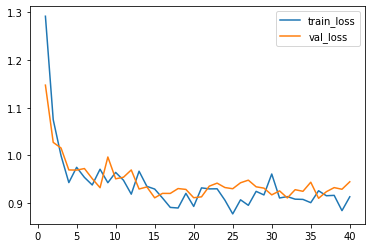

In [45]:
_ = history_df[['train_loss', 'val_loss']].plot.line()

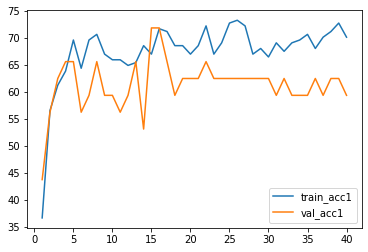

In [46]:
_ = history_df[['train_acc1', 'val_acc1']].plot.line()

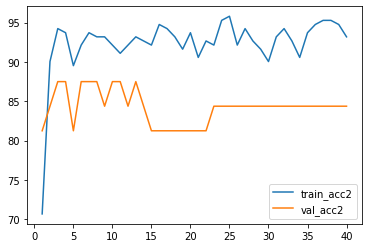

In [47]:
_ = history_df[['train_acc2', 'val_acc2']].plot.line()

# Test Set

In [48]:
test_loader, samples = get_val_loader(
    root_path + 'Split_images',
    lambda x: labels_df.loc[x].to_numpy(),
    2,
    test=True)

In [49]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/model_best.pth.tar')
backbone = cpkt['backbone']
linear = cpkt['linear']
best_epoch = cpkt['epoch']
print(cpkt['history_df']['val_acc1'][best_epoch])
print(best_epoch)

62.5
36


In [50]:
cpkt['history_df']['val_loss']

1     1.147194
2     1.027390
3     1.015609
4     0.969711
5     0.969364
6     0.972645
7     0.951509
8     0.932564
9     0.996821
10    0.951170
11    0.954435
12    0.969694
13    0.929795
14    0.934151
15    0.911377
16    0.920663
17    0.920583
18    0.930769
19    0.928963
20    0.911564
21    0.913440
22    0.935809
23    0.942086
24    0.932900
25    0.930396
26    0.942861
27    0.948333
28    0.934431
29    0.931656
30    0.917579
31    0.925893
32    0.911137
33    0.928398
34    0.924997
35    0.944030
36    0.910351
37         NaN
38         NaN
39         NaN
40         NaN
Name: val_loss, dtype: float64

In [51]:
backbone.eval()
linear.eval()

Sequential(
  (0): Normalize()
  (1): FullBatchNorm()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=16, out_features=16, bias=True)
  (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=16, out_features=4, bias=True)
)

In [52]:
preds, names, labels = None, None, None

with torch.no_grad():
    for indices, images, labels in test_loader:
        preds = linear(backbone(images)).softmax(dim=1).cpu().numpy()
        names = np.array([x.split('/')[-1] for x in samples])
        labels = labels.numpy()

df = pd.DataFrame(index=names)
preds = [list(x) for x in preds]
labels = [list(x) for x in labels]
df['target'] = labels
df['pred'] = preds
df.head()

,target,pred
Day 14_Y8-4-L.png,"[0.0, 0.0, 0.0909090909090909, 0.909090909090909]","[0.004571637, 0.027889019, 0.28118908, 0.6863502]"
Day 7_Y8-4-L.png,"[0.0, 0.0, 0.454545454545455, 0.545454545454545]","[0.03987059, 0.18062703, 0.57000995, 0.20949246]"
Day 9_A8-1-R.png,"[0.0909090909090909, 0.454545454545455, 0.4545...","[0.121226974, 0.3178256, 0.49249396, 0.06845342]"
Day 4_A8-1-R.png,"[0.363636363636364, 0.636363636363636, 0.0, 0.0]","[0.34626558, 0.45068535, 0.18969558, 0.013353588]"
Day 12_A8-1-R.png,"[0.0, 0.2, 0.5, 0.3]","[0.18174496, 0.3243465, 0.38720638, 0.10670216]"


In [53]:
props = df.index.map(lambda x: re.match('^Day (\d+)_(Y|A)8-(\d)-(L|R)', x).groups())
df['Day'] = props.map(lambda x: int(x[0]))
df['Age'] = props.map(lambda x: x[1])
df['Mouse'] = props.map(lambda x: int(x[2]))
df['Side'] = props.map(lambda x: x[3])
df['True, Pred'] = (df.index.map(lambda x: [np.argmax(df.loc[x]['target']), np.argmax(df.loc[x]['pred'])]))
df.head()

,target,pred,Day,Age,Mouse,Side,"True, Pred"
Day 14_Y8-4-L.png,"[0.0, 0.0, 0.0909090909090909, 0.909090909090909]","[0.004571637, 0.027889019, 0.28118908, 0.6863502]",14,Y,4,L,"[3, 3]"
Day 7_Y8-4-L.png,"[0.0, 0.0, 0.454545454545455, 0.545454545454545]","[0.03987059, 0.18062703, 0.57000995, 0.20949246]",7,Y,4,L,"[3, 2]"
Day 9_A8-1-R.png,"[0.0909090909090909, 0.454545454545455, 0.4545...","[0.121226974, 0.3178256, 0.49249396, 0.06845342]",9,A,1,R,"[1, 2]"
Day 4_A8-1-R.png,"[0.363636363636364, 0.636363636363636, 0.0, 0.0]","[0.34626558, 0.45068535, 0.18969558, 0.013353588]",4,A,1,R,"[1, 1]"
Day 12_A8-1-R.png,"[0.0, 0.2, 0.5, 0.3]","[0.18174496, 0.3243465, 0.38720638, 0.10670216]",12,A,1,R,"[2, 2]"


In [54]:
young_df = df[df.Age == 'Y']
young_df.sort_values('Day')[['target', 'pred', 'True, Pred']]

,target,pred,"True, Pred"
Day 0_Y8-4-L.png,"[1.0, 0.0, 0.0, 0.0]","[0.7823518, 0.19286281, 0.021386584, 0.0033988...","[0, 0]"
Day 1_Y8-4-L.png,"[0.57, 0.43, 0.0, 0.0]","[0.6989277, 0.22309212, 0.058718145, 0.019261982]","[0, 0]"
Day 2_Y8-4-L.png,"[0.8, 0.2, 0.0, 0.0]","[0.28924128, 0.46199685, 0.23650591, 0.012255902]","[0, 1]"
Day 3_Y8-4-L.png,"[0.2, 0.8, 0.0, 0.0]","[0.20569006, 0.3996702, 0.3615165, 0.033123143]","[1, 1]"
Day 4_Y8-4-L.png,"[0.4, 0.5, 0.1, 0.0]","[0.18802868, 0.3950429, 0.3708012, 0.04612715]","[1, 1]"
Day 5_Y8-4-L.png,"[0.3, 0.5, 0.2, 0.0]","[0.2108872, 0.43313882, 0.3258401, 0.030133909]","[1, 1]"
Day 6_Y8-4-L.png,"[0.1, 0.3, 0.6, 0.0]","[0.044086467, 0.17163573, 0.5588212, 0.22545661]","[2, 2]"
Day 7_Y8-4-L.png,"[0.0, 0.0, 0.454545454545455, 0.545454545454545]","[0.03987059, 0.18062703, 0.57000995, 0.20949246]","[3, 2]"
Day 8_Y8-4-L.png,"[0.0, 0.0, 0.6, 0.4]","[0.017529067, 0.09415988, 0.6123724, 0.27593863]","[2, 2]"
Day 9_Y8-4-L.png,"[0.0, 0.0, 0.6, 0.4]","[0.00900589, 0.06522366, 0.6036054, 0.32216507]","[2, 2]"


In [55]:
aged_df = df[df.Age == 'A']
aged_df.sort_values('Day')[['target', 'pred', 'True, Pred']]

,target,pred,"True, Pred"
Day 0_A8-1-R.png,"[0.9, 0.1, 0.0, 0.0]","[0.67528945, 0.28389144, 0.037134685, 0.003684...","[0, 0]"
Day 1_A8-1-R.png,"[0.1, 0.8, 0.1, 0.0]","[0.2535516, 0.45811877, 0.2690794, 0.019250257]","[1, 1]"
Day 2_A8-1-R.png,"[0.4, 0.5, 0.1, 0.0]","[0.20777601, 0.3526838, 0.3367335, 0.10280667]","[1, 1]"
Day 3_A8-1-R.png,"[0.4, 0.5, 0.1, 0.0]","[0.580088, 0.34211394, 0.06828936, 0.009508698]","[1, 0]"
Day 4_A8-1-R.png,"[0.363636363636364, 0.636363636363636, 0.0, 0.0]","[0.34626558, 0.45068535, 0.18969558, 0.013353588]","[1, 1]"
Day 5_A8-1-R.png,"[0.2, 0.5, 0.3, 0.0]","[0.1991626, 0.40783134, 0.32414934, 0.068856634]","[1, 1]"
Day 6_A8-1-R.png,"[0.2, 0.7, 0.1, 0.0]","[0.08537422, 0.2927712, 0.547608, 0.074246585]","[1, 2]"
Day 7_A8-1-R.png,"[0.1, 0.7, 0.1, 0.1]","[0.16166401, 0.40439695, 0.3765773, 0.057361722]","[1, 1]"
Day 8_A8-1-R.png,"[0.2, 0.6, 0.2, 0.0]","[0.06892993, 0.27883318, 0.57256234, 0.07967453]","[1, 2]"
Day 9_A8-1-R.png,"[0.0909090909090909, 0.454545454545455, 0.4545...","[0.121226974, 0.3178256, 0.49249396, 0.06845342]","[1, 2]"


In [56]:
test_acc = df['True, Pred'].map(lambda x: x[0] == x[1]).to_numpy().mean()
test_acc

0.75

# Some Cluster Analysis

In [233]:
data_path = root_path + 'Split_images'
weights_path = root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + epoch + '.pth'

encoder = get_model('resnet', 16, weights_path)
train_val_loader, train_samples = get_val_loader(data_path, lambda x: labels_df.loc[x].to_numpy(), 0, train=True)

In [234]:
encoder.eval()

with torch.no_grad():
    for indices, images, labels in train_val_loader:
        embeddings = encoder(images)

        _, fcm = fuzzy_c_means(embeddings, 4)
        preds = fcm.soft_predict(embeddings.numpy())
        labels = labels.numpy()
        x = 4


In [235]:
single_preds = preds.argmax(axis=1)
single_labels = labels.argmax(axis=1)

In [236]:
pred_indices_0 = [i for (i, x) in enumerate(single_preds) if x == 0]
pred_indices_1 = [i for (i, x) in enumerate(single_preds) if x == 1]
pred_indices_2 = [i for (i, x) in enumerate(single_preds) if x == 2]
pred_indices_3 = [i for (i, x) in enumerate(single_preds) if x == 3]

In [237]:
print(stats.mode(single_labels[pred_indices_0])[0][0])
print(stats.mode(single_labels[pred_indices_1])[0][0])
print(stats.mode(single_labels[pred_indices_2])[0][0])
print(stats.mode(single_labels[pred_indices_3])[0][0])

0
1
2
3


In [ ]:
single_labels[pred_indices_1]

array([3, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 3, 2, 2, 2, 2, 2])

In [ ]:
single_labels[pred_indices_2]

array([2, 1, 2, 2, 3, 2, 0, 2, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0,
       2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 0, 3, 2, 2, 2])

In [238]:
#have to change this m dict based on which clusters are which class
m = {0:0, 1:1, 2:2, 3:3}
preds = np.array([[p[m[0]], p[m[1]], p[m[2]], p[m[3]]] for p in preds])

In [239]:
single_preds = preds.argmax(axis=1)

In [240]:
acc = (single_preds == single_labels).mean()
acc

0.6178010471204188

# KNN Evaluation

### Misc Functions

In [57]:
def l2_normalize(x):
    return x / x.norm(2, dim=1, keepdim=True)

In [58]:
def log(string, file):
    print(string)
    file.write(string + '\n')

In [59]:
def faiss_knn(feats_train, targets_train, feats_val, targets_val, k):
    feats_train = feats_train.numpy()
    targets_train = targets_train.numpy()
    feats_val = feats_val.numpy()
    targets_val = targets_val.numpy()

    d = feats_train.shape[-1]

    index = faiss.IndexFlatL2(d)  # build the index
    co = faiss.GpuMultipleClonerOptions()
    co.useFloat16 = True
    co.shard = True
    gpu_index = faiss.index_cpu_to_all_gpus(index, co)
    gpu_index.add(feats_train)

    D, I = gpu_index.search(feats_val, k)

    pred = np.zeros(I.shape[0], dtype=np.int)
    conf_mat = np.zeros((1000, 1000), dtype=np.int)
    for i in range(I.shape[0]):
        votes = list(Counter(targets_train[I[i]]).items())
        shuffle(votes)
        pred[i] = max(votes, key=lambda x: x[1])[0]
        conf_mat[targets_val[i], pred[i]] += 1

    acc = 100.0 * (pred == targets_val).mean()
    assert acc == (100.0 * (np.trace(conf_mat) / np.sum(conf_mat)))

    # per_cat_acc = 100.0 * (np.diag(conf_mat) / np.sum(conf_mat, axis=1))
    # sparse_cats = [58, 155, 356, 747, 865, 234, 268, 384, 385, 491, 498, 538, 646, 650, 726, 860, 887, 15, 170, 231]
    # s = ' '.join('{}'.format(c) for c in sparse_cats)
    # print('==> cats: {}'.format(s))
    # s = ' '.join('{:.1f}'.format(a) for a in per_cat_acc[sparse_cats])
    # print('==> acc/cat: {}'.format(s))
    # print('==> mean acc: {}'.format(per_cat_acc[sparse_cats].mean()))

    return acc

In [60]:
def get_feats(loader, model, print_freq):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(loader),
        [batch_time],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    feats, labels, indices, ptr = None, None, None, 0

    with torch.no_grad():
        end = time.time()
        for i, (index, images, target) in enumerate(loader):
            images = images.cuda(non_blocking=True)
            cur_targets = target.cpu()
            cur_feats = model(images).cpu()
            cur_indices = index.cpu()

            B, D = cur_feats.shape
            inds = torch.arange(B) + ptr

            if not ptr:
                feats = torch.zeros((len(loader.dataset), D)).float()
                labels = torch.zeros(len(loader.dataset)).long()
                indices = torch.zeros(len(loader.dataset)).long()

            feats.index_copy_(0, inds, cur_feats)
            labels.index_copy_(0, inds, cur_targets)
            indices.index_copy_(0, inds, cur_indices)
            ptr += B

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

    return feats, labels, indices

In [61]:
def subset_classes(dataset, num_classes=10):
    np.random.seed(1234)
    all_classes = sorted(dataset.class_to_idx.items(), key=lambda x: x[1])
    subset_classes = [all_classes[i] for i in np.random.permutation(len(all_classes))[:num_classes]]
    subset_classes = sorted(subset_classes, key=lambda x: x[1])
    dataset.classes_to_idx = {c: i for i, (c, _) in enumerate(subset_classes)}
    dataset.classes = [c for c, _ in subset_classes]
    orig_to_new_inds = {orig_ind: new_ind for new_ind, (_, orig_ind) in enumerate(subset_classes)}
    dataset.samples = [(p, orig_to_new_inds[i]) for p, i in dataset.samples if i in orig_to_new_inds]

### Main Function

In [62]:
def main_worker(arch, output_dim, data_path, wts_path, output_path, batch_size, 
                label_fn, num_workers=2, print_freq=10):

    start = time.time()
    # Get train/val loader 
    # ---------------------------------------------------------------
    train_loader, _ = get_val_loader(data_path, label_fn, num_workers, batch_size, train=True)
    val_loader, _   = get_val_loader(data_path, label_fn, num_workers, batch_size)
    test_loader, _  = get_val_loader(data_path, label_fn, num_workers, batch_size, test=True)

    # Create and load the model
    # If you want to evaluate your model, modify this part and load your model
    # ------------------------------------------------------------------------
    # MODIFY 'get_model' TO EVALUATE YOUR MODEL
    model = get_model(arch, output_dim, wts_path).cuda()

    # ------------------------------------------------------------------------
    # Forward training samples throw the model and cache feats
    # ------------------------------------------------------------------------
    cudnn.benchmark = True

    train_feats, train_labels, train_inds = get_feats(train_loader, model, print_freq)

    val_feats, val_labels, val_inds = get_feats(val_loader, model, print_freq)

    test_feats, test_labels, test_inds = get_feats(test_loader, model, print_freq)

    # ------------------------------------------------------------------------
    # Calculate NN accuracy on validation set
    # ------------------------------------------------------------------------

    # train_feats = l2_normalize(train_feats)
    # val_feats = l2_normalize(val_feats)

    # mean = torch.mean(train_feats, dim=0)
    # std = torch.std(train_feats, dim=0)

    # stdmean = std.mean()
    # train_feats = train_feats / stdmean
    # val_feats = val_feats / stdmean

    # train_feats = train_feats / std
    # val_feats = val_feats / std

    # train_feats = (train_feats - mean) / std
    # val_feats = (val_feats - mean) / std

    # train_feats = train_feats - mean
    # val_feats = val_feats - mean

    # train_feats = train_feats / TEMP
    # val_feats = val_feats / TEMP

    train_feats = l2_normalize(train_feats)
    val_feats = l2_normalize(val_feats)
    test_feats = l2_normalize(test_feats)

    output = open(output_path, 'w')

    for k in range(1,21):
        log(f'k: {k}', output)
        val_acc  = faiss_knn(train_feats, train_labels, val_feats, val_labels, k)
        test_acc = faiss_knn(train_feats, train_labels, test_feats, test_labels, k)
        nn_time = time.time() - start
        log('=> time : {:.2f}s'.format(nn_time), output)
        log(' * Val_Acc {:.2f}'.format(val_acc), output)
        log(' * Test_Acc {:.2f}'.format(test_acc), output)

    output.close()

### Evaluation

In [64]:
main_worker(arch='resnet', 
            output_dim=16, 
            data_path=root_path + 'Split_images', 
            wts_path=root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + epoch + '.pth', 
            output_path=root_path + 'outputs/' + train_folder_name + 'eval' + eval_suffix + 'knn_' + epoch, 
            batch_size=8, 
            label_fn=lambda x: labels_map[x], 
            num_workers=2, 
            print_freq=10)

Test: [ 0/24]	Time  0.200 ( 0.200)
Test: [10/24]	Time  0.029 ( 0.055)
Test: [20/24]	Time  0.026 ( 0.049)
Test: [0/4]	Time  0.191 ( 0.191)
Test: [0/4]	Time  0.207 ( 0.207)
k: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

=> time : 3.10s
 * Val_Acc 56.25
 * Test_Acc 56.25
k: 2
=> time : 3.71s
 * Val_Acc 56.25
 * Test_Acc 50.00
k: 3
=> time : 4.31s
 * Val_Acc 62.50
 * Test_Acc 56.25
k: 4
=> time : 4.90s
 * Val_Acc 59.38
 * Test_Acc 65.62
k: 5
=> time : 5.49s
 * Val_Acc 62.50
 * Test_Acc 59.38
k: 6
=> time : 6.09s
 * Val_Acc 62.50
 * Test_Acc 59.38
k: 7
=> time : 6.70s
 * Val_Acc 56.25
 * Test_Acc 59.38
k: 8
=> time : 7.29s
 * Val_Acc 59.38
 * Test_Acc 59.38
k: 9
=> time : 7.89s
 * Val_Acc 56.25
 * Test_Acc 59.38
k: 10
=> time : 8.49s
 * Val_Acc 59.38
 * Test_Acc 59.38
k: 11
=> time : 9.08s
 * Val_Acc 59.38
 * Test_Acc 59.38
k: 12
=> time : 9.68s
 * Val_Acc 59.38
 * Test_Acc 59.38
k: 13
=> time : 10.28s
 * Val_Acc 59.38
 * Test_Acc 59.38
k: 14
=> time : 10.89s
 * Val_Acc 53.12
 * Test_Acc 59.38
k: 15
=> time : 11.50s
 * Val_Acc 53.12
 * Test_Acc 59.38
k: 16
=> time : 12.09s
 * Val_Acc 56.25
 * Test_Acc 62.50
k: 17
=> time : 12.69s
 * Val_Acc 59.38
 * Test_Acc 62.50
k: 18
=> time : 13.30s
 * Val_Acc 56.25
